# **Import Library and Load Dataset**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
dataset = pd.read_csv("Ads Experiment Dataset.csv")

print(dataset.shape)

dataset.head()

(8077, 9)


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


# **Data Preprocessing**

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [ ]:
dataset.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

*no null value*

**Delete observations without answers** ('yes' and 'no' columns, both equal to zero)

In [ ]:
dataset_nojwb = dataset[(dataset['yes'] == 0) & (dataset['no'] == 0)]

In [ ]:
dataset_terbaru = dataset.drop(dataset_nojwb.index)

print(dataset_terbaru.shape)

dataset_terbaru.head()

(1243, 9)


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


*from the previous 8077 observations, now there are 1243 observations left to be used*

# **Exploratory Data Analysis**

In [ ]:
exper = dataset_terbaru.groupby(['experiment']).sum()

exper

,hour,platform_os,yes,no
experiment,,,,
control,7282,3503,264,322
exposed,7038,3938,308,349


In [ ]:
dataset_terbaru['experiment'].value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

In [ ]:
jmlh_con = dataset_terbaru.experiment.value_counts().control

jmlh_con

586

In [ ]:
jmlh_exp = dataset_terbaru.experiment.value_counts().exposed

jmlh_exp

657

In [ ]:
exper_yes = dataset_terbaru.groupby('experiment')['yes'].sum()

exper_yes

experiment
control    264
exposed    308
Name: yes, dtype: int64

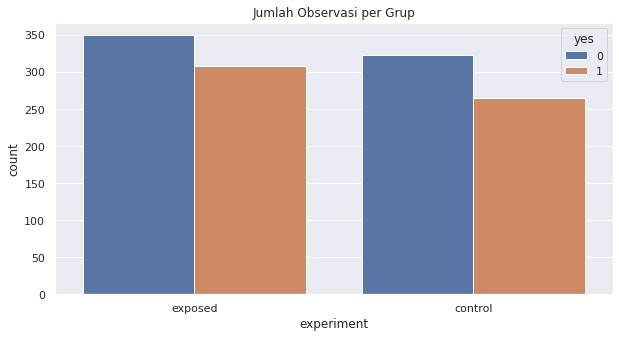

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='experiment', hue='yes', data=dataset_terbaru)
plt.title('Jumlah Observasi per Grup')

plt.show()
plt.close()

In [ ]:
con_yes = exper_yes.iloc[0]
exp_yes = exper_yes.iloc[1]

In [ ]:
persentase_con, persentase_exp = con_yes/jmlh_con, exp_yes/jmlh_exp

print('Ad Success untuk Grup Control sebesar {}%'.format((persentase_con*100).round(2)))
print('Ad Success untuk Grup Exposed sebesar {}%'.format((persentase_exp*100).round(2)))

Ad Success untuk Grup Control sebesar 45.05%
Ad Success untuk Grup Exposed sebesar 46.88%


*ad success was higher in the exposed group by 4% or 1.83 percentage points (pp)*

# **Statistical Significance**

In [ ]:
# Calculating the difference (improvement) we want to achieve, from 45% 'ad_success' to 50%
effect_size = sms.proportion_effectsize(0.45, 0.50)

In [ ]:
# Calculate the sample size needed (per group) to ensure that there is a significant difference.
required_n = np.ceil(sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1))

print(f'Jumlah observasi yang dibutuhkan oleh grup : {int(required_n)}')
print(f'Jumlah total observasi pada dataset : {dataset_terbaru.shape[0]}')

Jumlah observasi yang dibutuhkan oleh grup : 1565
Jumlah total observasi pada dataset : 1243


In [ ]:
con_yes = dataset_terbaru[dataset_terbaru.experiment == 'control']['yes']
exp_yes = dataset_terbaru[dataset_terbaru.experiment == 'exposed']['yes']

ad_succes_count = [con_yes.sum(), exp_yes.sum()]
obs_count = [con_yes.count(), exp_yes.count()]

In [ ]:
# Calculating the p-value of the ad success distribution
z_stat, pval = proportions_ztest(ad_succes_count, nobs=obs_count)

In [ ]:
# Calculating 95% confidence intervals
(l_ci_con, l_ci_exp), (u_ci_con, u_ci_exp) = proportion_confint(ad_succes_count, nobs=obs_count, alpha=0.05)

print('p-value dari ad success adalah {}'.format(pval.round(4)))
print(f'95% CI untuk ad success pada grup control adalah [{l_ci_con.round(4)}, {u_ci_con.round(4)}]')
print(f'95% CI untuk ad success pada grup exposed adalah [{l_ci_exp.round(4)}, {u_ci_exp.round(4)}]')

p-value dari ad success adalah 0.5185
95% CI untuk ad success pada grup control adalah [0.4102, 0.4908]
95% CI untuk ad success pada grup exposed adalah [0.4306, 0.507]


In [ ]:
# Simulation
n = 100000
std_a = np.sqrt(persentase_con * (1-persentase_con)/jmlh_con)
std_b = np.sqrt(persentase_exp * (1-persentase_exp)/jmlh_exp)

rates_con = norm(persentase_con, std_a).rvs(n)
rates_exp = norm(persentase_exp, std_b).rvs(n)

exp_better = (rates_exp>rates_con).mean()

print(exp_better)
print(1-exp_better)

0.7411
0.2589
